<a href="https://colab.research.google.com/github/IvoandricGBC/Project-MLI-GBC/blob/main/Multi_modal_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1.1 Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 1.2 Instalar dependencias
#!pip install --upgrade pip setuptools wheel
#!pip install torch torchvision pandas scikit-learn matplotlib




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Ajusta esta ruta al directorio donde están tus datos en Drive
BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/Multi-modal classification"
CSV_PATH = os.path.join(BASE_DIR, "labels.csv")
IMGS_DIR = os.path.join(BASE_DIR, "images")

# Verificar existencia
assert os.path.isfile(CSV_PATH), f"No existe {CSV_PATH}"
assert os.path.isdir(IMGS_DIR),  f"No existe {IMGS_DIR}"
print("✅ Rutas verificadas")





✅ Rutas verificadas


In [3]:
# 3.1 Leer CSV
df = pd.read_csv(CSV_PATH)

# 3.2 Remapear etiquetas originales (10–79) a 0…C-1
le = LabelEncoder()
df['label_enc'] = le.fit_transform(df['label'])
num_classes = len(le.classes_)
print(f"Clases originales: {len(le.classes_)} → etiquetas 0…{num_classes-1}")

# 3.3 Crear columna image_path (asumiendo que ID coincide con nombre PNG)
df['image_path'] = df['ID'].astype(str) + '.png'

# 3.4 Construir diccionario label→[índices] para muestreo rápido
label_to_indices = {
    lbl: df.index[df['label_enc']==lbl].tolist()
    for lbl in df['label_enc'].unique()
}
print(f"Tienes {len(label_to_indices)} etiquetas distintas en el dataset")




Clases originales: 70 → etiquetas 0…69
Tienes 70 etiquetas distintas en el dataset


In [4]:
# Definir cuántas clases y ejemplos por episodio
WAYS    = 5    # N clases por episodio
SHOTS   = 1    # K ejemplos de soporte por clase
QUERIES = 5    # Q ejemplos de consulta por clase

# Muestras mínimas que debe tener cada etiqueta
MIN_SAMPLES = SHOTS + QUERIES
print(f"Few-shot config: {WAYS}-ways, {SHOTS}-shots, {QUERIES}-queries "
      f"(mínimo {MIN_SAMPLES} muestras/clase)")



Few-shot config: 5-ways, 1-shots, 5-queries (mínimo 6 muestras/clase)


In [5]:
# Solo conservar etiquetas con ≥ MIN_SAMPLES ejemplos
valid_labels = [
    lbl for lbl, inds in label_to_indices.items()
    if len(inds) >= MIN_SAMPLES
]
print(f"Etiquetas totales: {len(label_to_indices)}  → válidas: {len(valid_labels)}")

if len(valid_labels) < WAYS:
    raise ValueError(f"Pocas clases válidas: {len(valid_labels)} < WAYS ({WAYS})")


Etiquetas totales: 70  → válidas: 41


In [6]:
train_img_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([.485,.456,.406], [.229,.224,.225]),
])
val_img_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([.485,.456,.406], [.229,.224,.225]),
])


In [7]:
def sample_episode(df, label_to_indices, valid_labels,
                   ways, shots, queries, img_trans, img_dir):
    """
    Retorna:
      support_imgs, support_meta, support_labels,
      query_imgs,   query_meta,   query_labels
    """
    chosen = random.sample(valid_labels, ways)
    supp_imgs, supp_meta, supp_lbls = [], [], []
    qry_imgs,  qry_meta,  qry_lbls  = [], [], []

    for lbl in chosen:
        indices = random.sample(label_to_indices[lbl], shots + queries)
        for i, idx in enumerate(indices):
            row = df.loc[idx]
            # Imagen
            img = Image.open(os.path.join(img_dir, row.image_path)).convert('RGB')
            img = img_trans(img)
            # Metadatos
            meta = torch.tensor(
                [row.ID, row['class'], row.Width, row.location],
                dtype=torch.float32
            )
            # Asignar a soporte o consulta
            if i < shots:
                supp_imgs.append(img);   supp_meta.append(meta);   supp_lbls.append(lbl)
            else:
                qry_imgs.append(img);    qry_meta.append(meta);    qry_lbls.append(lbl)

    # Apilar tensores
    support_imgs   = torch.stack(supp_imgs)
    support_meta   = torch.stack(supp_meta)
    support_labels = torch.tensor(supp_lbls, dtype=torch.long)
    query_imgs     = torch.stack(qry_imgs)
    query_meta     = torch.stack(qry_meta)
    query_labels   = torch.tensor(qry_lbls, dtype=torch.long)

    return support_imgs, support_meta, support_labels, query_imgs, query_meta, query_labels




In [8]:
class MultiModalEmbedder(nn.Module):
    def __init__(self, backbone='resnet18', img_dim=128, meta_dim=32):
        super().__init__()
        # Encoder de imagen
        cnn = getattr(models, backbone)(weights=models.ResNet18_Weights.DEFAULT)
        cnn.fc = nn.Linear(cnn.fc.in_features, img_dim)
        self.img_enc  = cnn
        # Encoder de metadatos
        self.meta_enc = nn.Sequential(
            nn.Linear(4, 64), nn.ReLU(),
            nn.Linear(64, meta_dim), nn.ReLU(),
        )

    def forward(self, img, meta):
        e1 = self.img_enc(img)          # (batch, img_dim)
        e2 = self.meta_enc(meta)        # (batch, meta_dim)
        return torch.cat([e1, e2], dim=1)  # (batch, img_dim+meta_dim)



In [9]:
def prototypical_loss(embeddings, ways, shots, queries):
    """
    embeddings: tensor (ways*(shots+queries), D)
    Devuelve: (loss, acc)
    """
    D = embeddings.size(-1)
    # 1) Separar soporte y consulta
    support = embeddings[:ways*shots].view(ways, shots, D)
    query   = embeddings[ways*shots:].view(ways*queries, D)
    # 2) Calcular prototypes
    prototypes = support.mean(dim=1)  # (ways, D)
    # 3) Distancias euclidianas
    dists = torch.cdist(query, prototypes)  # (ways*queries, ways)
    # 4) Logits y targets
    logits = -dists
    target_inds = torch.arange(ways).unsqueeze(1)\
                       .expand(ways, queries).reshape(-1)\
                       .to(logits.device)
    # 5) Loss y accuracy
    loss = nn.CrossEntropyLoss()(logits, target_inds)
    preds = torch.argmax(logits, dim=1)
    acc  = (preds == target_inds).float().mean().item()
    return loss, acc


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 82.8MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 01  TrainLoss=27.4392  TrainAcc=0.5028  |  ValLoss=0.9047  ValAcc=0.7672
Epoch 02  TrainLoss=0.6027  TrainAcc=0.7172  |  ValLoss=0.7648  ValAcc=0.7648
Epoch 03  TrainLoss=0.4734  TrainAcc=0.7770  |  ValLoss=0.4524  ValAcc=0.8424
Epoch 04  TrainLoss=0.5063  TrainAcc=0.7800  |  ValLoss=0.4224  ValAcc=0.8544
Epoch 05  TrainLoss=0.4353  TrainAcc=0.7962  |  ValLoss=0.4545  ValAcc=0.8448
Epoch 06  TrainLoss=0.4442  TrainAcc=0.7956  |  ValLoss=0.4079  ValAcc=0.8760
Epoch 07  TrainLoss=0.3831  TrainAcc=0.8178  |  ValLoss=0.2710  ValAcc=0.9152
Epoch 08  TrainLoss=0.3821  TrainAcc=0.8266  |  ValLoss=0.2517  ValAcc=0.9320
Epoch 09  TrainLoss=0.3300  TrainAcc=0.8560  |  ValLoss=0.2960  ValAcc=0.9096
Epoch 10  TrainLoss=0.3451  TrainAcc=0.8386  |  ValLoss=0.2201  ValAcc=0.9096


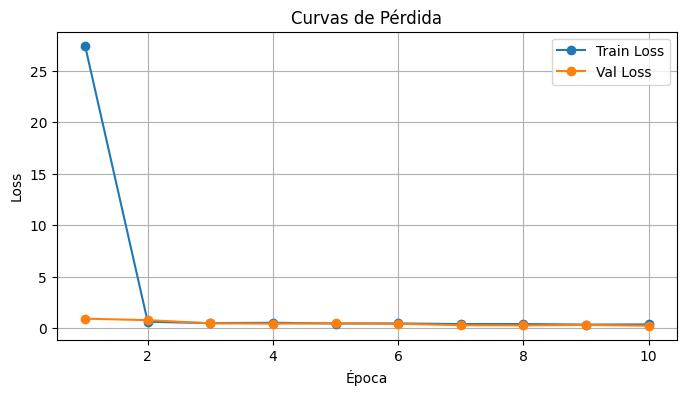

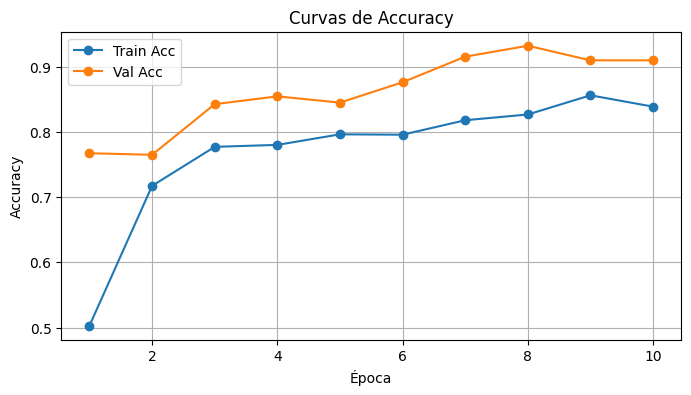

In [10]:
# ── Módulo 8 – Entrenamiento, validación, early stopping y scheduler ─────────────

# 8.0 Importar para graficar
import matplotlib.pyplot as plt
import os

# 8.1 Hiperparámetros y device
EPISODES_TRAIN = 200
EPISODES_VAL   =  50
EPOCHS         =  10
device         = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 8.2 Instanciar modelo y optimizador
embedder  = MultiModalEmbedder().to(device)
optimizer = optim.Adam(embedder.parameters(), lr=1e-3)

# 8.2.1 Scheduler sobre val_loss
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,      # reducir lr a la mitad
    patience=2,      # espera 2 épocas sin mejora
    verbose=True
)

# 8.2.2 Variables para early stopping
best_val_acc     = 0.0
patience_counter = 0
PATIENCE         = 3   # detener si no mejora val_acc en 3 épocas

# 8.3 Listas para métricas
train_losses, train_accs = [], []
val_losses,   val_accs   = [], []

# 8.4 Bucle de entrenamiento + validación
for epoch in range(1, EPOCHS+1):
    # — Entrenamiento —
    embedder.train()
    running_loss, running_acc = 0.0, 0.0
    for _ in range(EPISODES_TRAIN):
        s_img, s_meta, s_lbl, q_img, q_meta, q_lbl = sample_episode(
            df, label_to_indices, valid_labels,
            WAYS, SHOTS, QUERIES,
            train_img_transforms, IMGS_DIR
        )
        s_img, s_meta, s_lbl = s_img.to(device), s_meta.to(device), s_lbl.to(device)
        q_img, q_meta        = q_img.to(device), q_meta.to(device)

        emb_s   = embedder(s_img, s_meta)
        emb_q   = embedder(q_img, q_meta)
        emb_all = torch.cat([emb_s, emb_q], dim=0)

        loss, acc = prototypical_loss(emb_all, WAYS, SHOTS, QUERIES)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc  += acc

    train_loss = running_loss / EPISODES_TRAIN
    train_acc  = running_acc  / EPISODES_TRAIN

    # — Validación —
    embedder.eval()
    running_val_loss, running_val_acc = 0.0, 0.0
    with torch.no_grad():
        for _ in range(EPISODES_VAL):
            s_img, s_meta, s_lbl, q_img, q_meta, q_lbl = sample_episode(
                df, label_to_indices, valid_labels,
                WAYS, SHOTS, QUERIES,
                val_img_transforms, IMGS_DIR
            )
            s_img, s_meta, s_lbl = s_img.to(device), s_meta.to(device), s_lbl.to(device)
            q_img, q_meta        = q_img.to(device), q_meta.to(device)

            emb_s   = embedder(s_img, s_meta)
            emb_q   = embedder(q_img, q_meta)
            emb_all = torch.cat([emb_s, emb_q], dim=0)

            loss, acc = prototypical_loss(emb_all, WAYS, SHOTS, QUERIES)
            running_val_loss += loss.item()
            running_val_acc  += acc

    val_loss = running_val_loss / EPISODES_VAL
    val_acc  = running_val_acc  / EPISODES_VAL

    # 8.5 Guardar métricas
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # 8.6 Early stopping + checkpoint
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(
            embedder.state_dict(),
            os.path.join(BASE_DIR, 'best_embedder.pth')
        )
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"⏹ Early stopping en época {epoch} (no mejora en {PATIENCE} épocas).")
            break

    # 8.7 Scheduler step sobre val_loss
    scheduler.step(val_loss)

    # 8.8 Impresión de progreso
    print(
        f"Epoch {epoch:02d}  "
        f"TrainLoss={train_loss:.4f}  TrainAcc={train_acc:.4f}  |  "
        f"ValLoss={val_loss:.4f}  ValAcc={val_acc:.4f}"
    )

# 8.9 Graficar curvas de pérdida
epochs = range(1, len(train_losses)+1)
plt.figure(figsize=(8,4))
plt.plot(epochs, train_losses, '-o', label='Train Loss')
plt.plot(epochs, val_losses,   '-o', label='Val Loss')
plt.title('Curvas de Pérdida')
plt.xlabel('Época'); plt.ylabel('Loss')
plt.legend(); plt.grid(True); plt.show()

# 8.10 Graficar curvas de accuracy
plt.figure(figsize=(8,4))
plt.plot(epochs, train_accs, '-o', label='Train Acc')
plt.plot(epochs, val_accs,   '-o', label='Val Acc')
plt.title('Curvas de Accuracy')
plt.xlabel('Época'); plt.ylabel('Accuracy')
plt.legend(); plt.grid(True); plt.show()

